In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import defaultdict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# loading the diabetes dataset to a pandas DataFrame
df = pd.read_csv('..\dataset\diabetes.csv')

In [3]:
df.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
# Shape Of The Dataset
df.shape

(100000, 9)

In [5]:
# let’s see if there are null valuecs
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [6]:
# some info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [7]:
# convert object data to string 
string_col = df.select_dtypes(include='object').columns
df[string_col]=df[string_col].astype('string')

In [8]:
df.dtypes

gender                 string[python]
age                           float64
hypertension                    int64
heart_disease                   int64
smoking_history        string[python]
bmi                           float64
HbA1c_level                   float64
blood_glucose_level             int64
diabetes                        int64
dtype: object

In [9]:
df['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: Int64

In [10]:
df['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: Int64

In [11]:
df[df['gender']== 'Other']

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
12669,Other,10.0,0,0,not current,14.09,5.0,140,0
14838,Other,19.0,0,0,No Info,27.32,5.7,158,0
16702,Other,39.0,0,0,not current,31.24,6.2,85,0
18691,Other,10.0,0,0,not current,16.59,6.1,160,0
23266,Other,23.0,0,0,No Info,24.23,6.1,140,0
31985,Other,53.0,0,0,No Info,27.32,6.6,160,0
33805,Other,45.0,0,0,never,27.32,4.0,159,0
34929,Other,47.0,0,0,never,36.76,6.6,90,0
35006,Other,47.0,0,0,never,36.76,3.5,200,0
40337,Other,18.0,0,0,not current,30.19,6.1,90,0


In [12]:
df = df[df['gender'] != 'Other']

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,99982.0,41.888076,22.517206,0.08,24.00,43.00,60.00,80.00
hypertension,99982.0,0.074863,0.263172,0.00,0.00,0.00,0.00,1.00
heart_disease,99982.0,0.039427,0.194610,0.00,0.00,0.00,0.00,1.00
bmi,99982.0,27.320757,6.636853,10.01,23.63,27.32,29.58,95.69
HbA1c_level,99982.0,5.527529,1.070665,3.50,4.80,5.80,6.20,9.00
blood_glucose_level,99982.0,138.057810,40.709469,80.00,100.00,140.00,159.00,300.00
diabetes,99982.0,0.085015,0.278906,0.00,0.00,0.00,0.00,1.00


In [14]:
# let’s see if there are duplicated values
df.duplicated().sum()

3854

In [15]:
# remove duplicates
df= df.drop_duplicates()

In [16]:
df.duplicated().sum()

0

In [17]:
def Outliers(df, feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr

    upper = q3 + 1.5 * iqr
    
    df_clean = df[(df[feature] >= lower) & (df[feature] <= upper)]
    return df_clean  # Return the cleaned data

In [18]:
#there are outliers in bmi ,HbA1c_level and blood_glucose_level
df_clean = Outliers(df, 'bmi')
df_clean = Outliers(df, 'HbA1c_level')
df_clean = Outliers(df, 'blood_glucose_level')

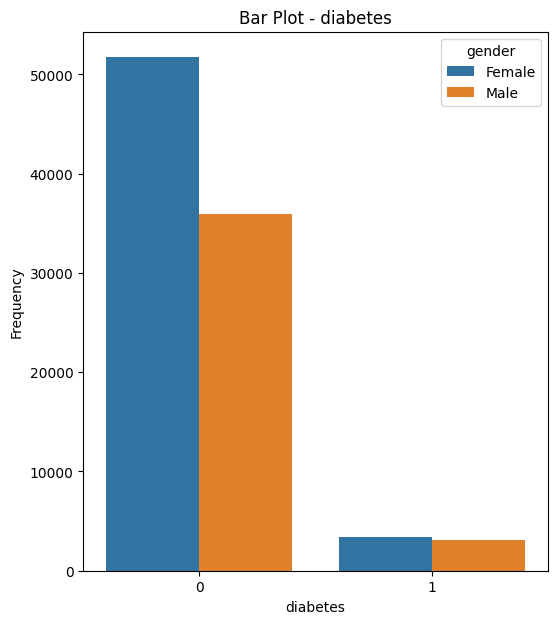

In [19]:
# Perform univariate analysis for diabetes
plt.figure(figsize=(6, 7))
sns.countplot(data=df_clean, x="diabetes",hue='gender')
plt.xlabel("diabetes")
plt.ylabel("Frequency")
plt.title("Bar Plot - diabetes")
plt.show()

In [20]:
print(df_clean['gender'].value_counts())

gender
Female    55093
Male      39004
Name: count, dtype: Int64


In [21]:
# Define a function to map the existing categories to new ones
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply the function to the 'smoking_history' column
df_clean['smoking_history'] = df_clean['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df_clean['smoking_history'].value_counts())

smoking_history
non-smoker     66148
past_smoker    19001
current         8948
Name: count, dtype: int64


C:\Users\nkcho\AppData\Local\Temp\ipykernel_17812\3212530590.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['smoking_history'] = df_clean['smoking_history'].apply(recategorize_smoking)


In [22]:
df_clean

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,non-smoker,25.19,6.6,140,0
1,Female,54.0,0,0,non-smoker,27.32,6.6,80,0
2,Male,28.0,0,0,non-smoker,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99994,Female,36.0,0,0,non-smoker,24.60,4.8,145,0
99996,Female,2.0,0,0,non-smoker,17.37,6.5,100,0
99997,Male,66.0,0,0,past_smoker,27.83,5.7,155,0
99998,Female,24.0,0,0,non-smoker,35.42,4.0,100,0


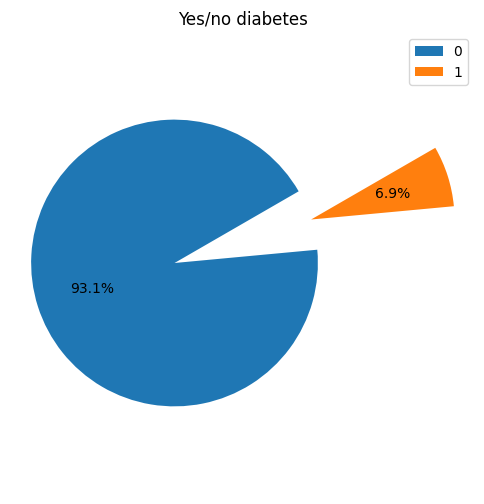

In [23]:
# check the balance of the target class
def balanced_plot(data):

    plt.figure(figsize=(6, 6))
    plt.pie(df_clean.diabetes.value_counts(), 
            df_clean.diabetes.value_counts().index, 
            autopct='%1.1f%%', 
            startangle=30)
    plt.axis('equal')
    plt.legend(df_clean.diabetes.value_counts().index, loc='best')
    plt.title('Yes/no diabetes')
    plt.show()
    
balanced_plot(df_clean)

In [24]:
# Load data and encode categorical features
df_encoded = pd.get_dummies(df_clean, columns=['gender', 'smoking_history'],dtype=int, drop_first=True)

In [25]:
# Spliting data
X = df_encoded.drop('diabetes', axis=1).values
y = df_encoded['diabetes'].values

In [26]:
# Define preprocessor for NumPy arrays
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [0, 1, 2, 3, 4, 5]),  #  column indices
        ('cat', OneHotEncoder(drop='first'), [6, 7, 8])   #  column indices
    ])

In [27]:
# Define model
model = {'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric="error", objective="binary:logistic")}

# KFold cross-validation for evaluation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store results across folds
results = defaultdict(lambda: defaultdict(list))

In [28]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, model_name, fold):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    plt.title(f"Confusion Matrix for {model_name} (Fold {fold})")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Function to apply SMOTE and RandomUnderSampler
def apply_resampling(X_train, y_train):
    # Apply SMOTE to the training data
    smote = SMOTE(sampling_strategy=0.1)  # Adjust sampling strategy as needed
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Apply RandomUnderSampler to the resampled data
    under_sampler = RandomUnderSampler(sampling_strategy=0.5)  # Adjust sampling strategy as needed
    X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train_resampled, y_train_resampled)

    return X_train_resampled, y_train_resampled

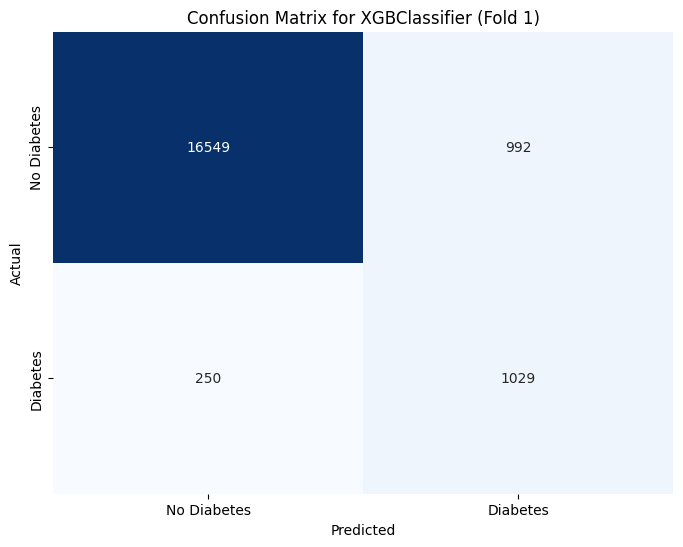

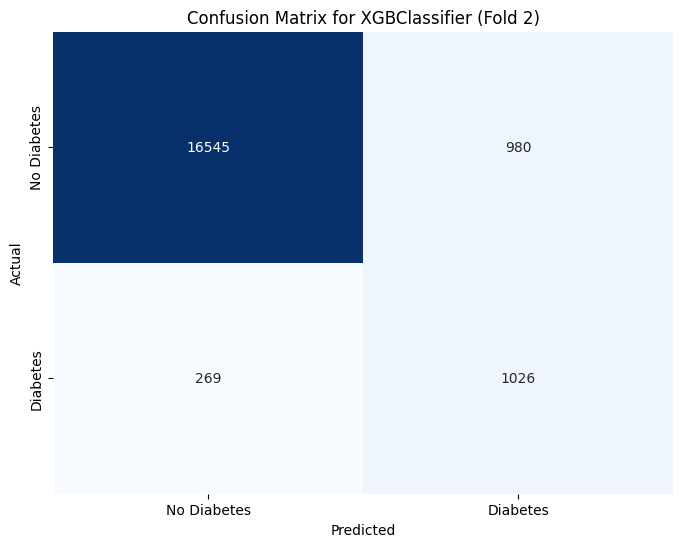

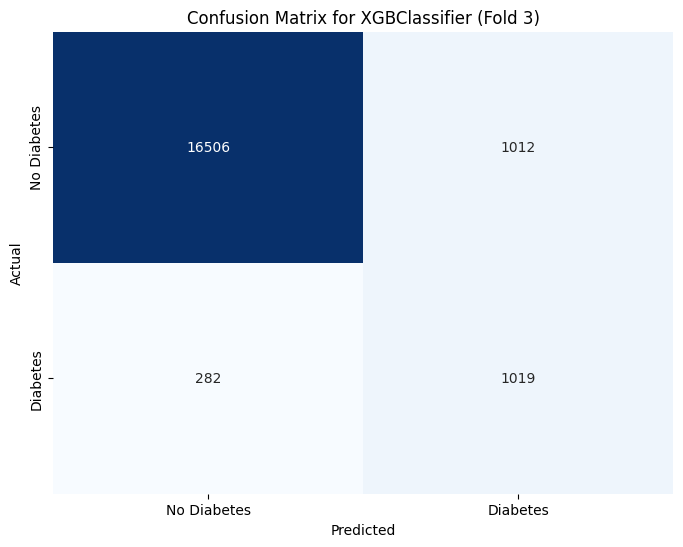

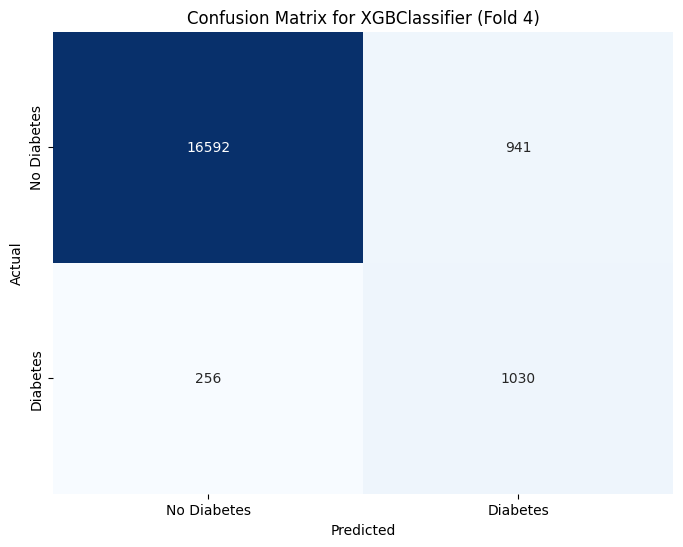

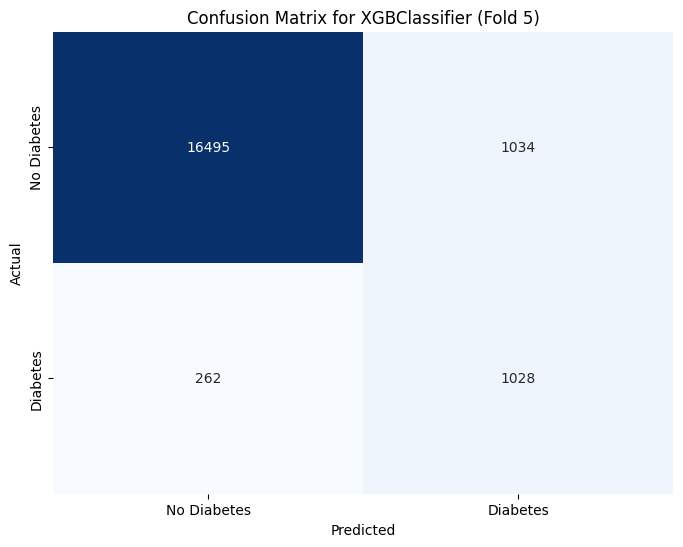

In [29]:
# Iterate through model and perform cross-validation
for model_name, model in model.items():
    for fold, (train_index, test_index) in enumerate(cv.split(X), 1):
        # Split data into train and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Apply SMOTE and RandomUnderSampler to the training data
        X_train_resampled, y_train_resampled = apply_resampling(X_train, y_train)

        # Define pipeline steps
        pipe_steps = [
        ('preprocessor', preprocessor),
        ('classifier', model)
        ]

        # Create the pipeline
        pipeline = Pipeline(steps=pipe_steps)

        # Fit the pipeline on the resampled training data
        pipeline.fit(X_train_resampled, y_train_resampled)
        # Evaluate the pipeline on the test data
        y_pred = pipeline.predict(X_test)

        # Store metrics for each fold
        results[model_name]['accuracy'].append(accuracy_score(y_test, y_pred))
        results[model_name]['precision'].append(precision_score(y_test, y_pred))
        results[model_name]['recall'].append(recall_score(y_test, y_pred))
        results[model_name]['f1'].append(f1_score(y_test, y_pred))
        
        # Print confusion matrix for each fold
        cm = confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(cm, model_name, fold)

In [30]:
for model_name, metrics in results.items():
    mean_accuracy = np.mean(metrics['accuracy'])
    mean_precision = np.mean(metrics['precision'])
    mean_recall = np.mean(metrics['recall'])
    mean_f1 = np.mean(metrics['f1'])

print(f"\nModel: {model_name}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-score: {mean_f1:.4f}")


Model: XGBClassifier
Mean Accuracy: 0.9333
Mean Precision: 0.5087
Mean Recall: 0.7956
Mean F1-score: 0.6206


In [31]:
# Parameters for XGBClassifier
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
    'classifier__min_child_weight': [1, 2, 3],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit the randomized search to the data
random_search.fit(X, y)

# Display the best parameters and the corresponding mean cross-validated score
print(f"\nBest Parameters for {model_name}: {random_search.best_params_}")
print(f"Best Mean Accuracy for {model_name}: {random_search.best_score_:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters for XGBClassifier: {'classifier__subsample': 0.8, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 3, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 1.0}
Best Mean Accuracy for XGBClassifier: 0.9704


In [41]:
# Set the best hyperparameters
best_params = {
    'classifier__subsample': 0.8,
    'classifier__n_estimators': 200,
    'classifier__min_child_weight': 3,
    'classifier__max_depth': 3,
    'classifier__learning_rate': 0.1,
    'classifier__colsample_bytree': 1.0
}

# Update the pipeline with the best hyperparameters
pipeline.set_params(**best_params)

# Train the final model on the entire training dataset
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  [0, 1, 2, 3, 4, 5]),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  [6, 7, 8])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=Fals...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [33]:
y_pred_test = pipeline.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

Test Accuracy: 0.9713
Test Precision: 0.9832
Test Recall: 0.5907
Test F1-score: 0.7380


In [34]:
import pickle

In [35]:
filename = 'diabetes_prediction_model.sav'
pickle.dump(pipeline, open(filename, 'wb'))

In [36]:
# loading the saved model
loaded_model = pickle.load(open('diabetes_prediction_model.sav', 'rb'))

In [37]:
loaded_model.n_features_in_

9

In [38]:
df_encoded.columns

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes', 'gender_Male',
       'smoking_history_non-smoker', 'smoking_history_past_smoker'],
      dtype='object')

In [39]:
df_encoded[df_encoded['diabetes']==1]

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,smoking_history_non-smoker,smoking_history_past_smoker
6,44.0,0,0,19.31,6.5,200,1,0,1,0
26,67.0,0,1,27.32,6.5,200,1,1,0,1
40,73.0,0,0,25.91,9.0,160,1,1,0,1
53,53.0,0,0,27.32,7.0,159,1,0,0,1
55,50.0,0,0,37.16,9.0,159,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
99919,74.0,0,0,29.51,8.2,130,1,0,0,0
99929,37.0,0,0,36.87,8.8,160,1,0,1,0
99935,65.0,1,1,33.55,8.2,140,1,0,1,0
99962,58.0,1,0,38.31,7.0,200,1,0,1,0


In [40]:
# Create a NumPy array for the new data point
new_data_point = np.array([[74.0, 0, 0, 29.51, 8.2, 130, 0, 1, 0]])

# Make predictions using the loaded model
prediction = loaded_model.predict(new_data_point)

# Make predictions using the loaded model
prediction = loaded_model.predict(new_data_point)

# Display the prediction
print("Prediction:", prediction)

# Display the prediction
if prediction==0:
    print("Person is not diabetic.")
else:
    print("Person is diabetic.")

Prediction: [1]
Person is diabetic.
